In [294]:
import collections
import sys
import os
import re
import time
import numpy as np
import pandas as pd

In [295]:
class StubLogger(object):
    def __getattr__(self, name):
        return self.log_print

    def log_print(self, msg, *args):
        print(msg % args)

LOGGER = StubLogger()
LOGGER.info("Hello %s!", "world")

Hello world!


In [296]:
import contextlib
import time

@contextlib.contextmanager
def elapsed_timer(message):
    start_time = time.time()
    yield
    LOGGER.info(message.format(time.time() - start_time))

# Evaluation mechanism

Evaluation Functions

In [297]:
def hitsAtK(user_ranks, k=10):
    return (user_ranks["rank"].notna() & (user_ranks["rank"] <= k)).sum(skipna=True)


def precisionAtK(user_ranks, k):
    precision = float(hitsAtK(user_ranks, k)) / k
    return precision


def recallAtK(user_ranks, k):
    recall = float(hitsAtK(user_ranks, k)) / user_ranks.shape[0]
    return recall


def averagePrecisionAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_correct_user_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]

    if k_correct_user_ranks.shape[0] > 0:
        #print k_correct_user_ranks
        score = 0.0
        for row in range(k_correct_user_ranks.shape[0]):
            tmp_user_ranks = k_correct_user_ranks.head(row + 1)
            row_k = k_correct_user_ranks.iloc[row]["rank"]
            score = score + precisionAtK(tmp_user_ranks, row_k)
        avgPrec = float(score) / min(user_ranks.shape[0], k)
    else:
        avgPrec = 0.0
    return avgPrec


def ndcgAtK(user_ranks, k):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1)


    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]["rank"].values

    ranks_idcg = dcg(np.arange(1, k_user_ranks.shape[0] + 1))
    ranks_dcg = dcg(k_ranks)

    ndcg = float(np.sum(ranks_dcg)) / np.sum(ranks_idcg)
    return ndcg


def topEventsAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    return pd.DataFrame({
        "event_id": k_user_ranks["event_id"].drop_duplicates().sort_values()
    })

In [298]:
def quickMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
    })


def basicMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })


def quadMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_50": [precisionAtK(user_ranks, 50)],
        "precision_at_20": [precisionAtK(user_ranks, 20)],
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "precision_at_5": [precisionAtK(user_ranks, 5)],
        "recall_at_50": [recallAtK(user_ranks, 50)],
        "recall_at_20": [recallAtK(user_ranks, 20)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "recall_at_5": [recallAtK(user_ranks, 5)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "ndcg_at_5": [ndcgAtK(user_ranks, 5)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
        "avg_prec_at_5": [averagePrecisionAtK(user_ranks, 5)],
    })

In [299]:
def evalMetrics(rank_data, *, runMetricsPerUser=None):
    if runMetricsPerUser is None:
        runMetricsPerUser = quadMetricsPerUser

    user_metrics = rank_data.groupby("user_id").apply(runMetricsPerUser)
    top_events_at_10 = rank_data.groupby("user_id").apply(topEventsAtK, 10)
    top_events_at_20 = rank_data.groupby("user_id").apply(topEventsAtK, 20)

    metrics = dict()
    # Precision
    if "precision_at_50" in user_metrics.columns:
        precision_50 = user_metrics["precision_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_50"] = [precision_50]
    if "precision_at_20" in user_metrics.columns:
        precision_20 = user_metrics["precision_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_20"] = [precision_20]
    if "precision_at_10" in user_metrics.columns:
        precision_10 = user_metrics["precision_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_10"] = [precision_10]
    if "precision_at_5" in user_metrics.columns:
        precision_5 = user_metrics["precision_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_5"] = [precision_5]

    # Recall
    if "recall_at_50" in user_metrics.columns:
        recall_50 = user_metrics["recall_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_50"] = [recall_50]
    if "recall_at_20" in user_metrics.columns:
        recall_20 = user_metrics["recall_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_20"] = [recall_20]
    if "recall_at_10" in user_metrics.columns:
        recall_10 = user_metrics["recall_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_10"] = [recall_10]
    if "recall_at_5" in user_metrics.columns:
        recall_5 = user_metrics["recall_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_5"] = [recall_5]

    # F1 Score
    if "precision_at_50" in user_metrics.columns and "recall_at_50" in user_metrics.columns:
        if precision_50 + recall_50 > 0:
            f1_score_50 =  2 * ((precision_50 * recall_50) / (precision_50 + recall_50))
        else:
            f1_score_50 = 0.0
        metrics["f1_score_at_50"] = [f1_score_50]
    if "precision_at_20" in user_metrics.columns and "recall_at_20" in user_metrics.columns:
        if precision_20 + recall_20 > 0:
            f1_score_20 =  2 * ((precision_20 * recall_20) / (precision_20 + recall_20))
        else:
            f1_score_20 = 0.0
        metrics["f1_score_at_20"] = [f1_score_20]
    if "precision_at_10" in user_metrics.columns and "recall_at_10" in user_metrics.columns:
        if precision_10 + recall_10 > 0:
            f1_score_10 =  2 * ((precision_10 * recall_10) / (precision_10 + recall_10))
        else:
            f1_score_10 = 0.0
        metrics["f1_score_at_10"] = [f1_score_10]
    if "precision_at_5" in user_metrics.columns and "recall_at_5" in user_metrics.columns:
        if precision_5 + recall_5 > 0:
            f1_score_5 =  2 * ((precision_5 * recall_5) / (precision_5 + recall_5))
        else:
            f1_score_5 = 0.0
        metrics["f1_score_at_5"] = [f1_score_5]

    # NDCG@50
    if "ndcg_at_50" in user_metrics.columns:
        ndcg_50 = user_metrics["ndcg_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_50"] = [ndcg_50]
    # NDCG@20
    if "ndcg_at_20" in user_metrics.columns:
        ndcg_20 = user_metrics["ndcg_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_20"] = [ndcg_20]
    # NDCG@10
    if "ndcg_at_10" in user_metrics.columns:
        ndcg_10 = user_metrics["ndcg_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_10"] = [ndcg_10]
    
    if "ndcg_at_5" in user_metrics.columns:
        ndcg_5 = user_metrics["ndcg_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_5"] = [ndcg_5]
    # MAP@20
    if "avg_prec_at_20" in user_metrics.columns:
        map_at_20 = user_metrics["avg_prec_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_20"] = [map_at_20]
    # MAP@10
    if "avg_prec_at_10" in user_metrics.columns:
        map_at_10 = user_metrics["avg_prec_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_10"] = [map_at_10]
    
    if "avg_prec_at_5" in user_metrics.columns:
        map_at_5 = user_metrics["avg_prec_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_5"] = [map_at_5]

    # Mean Rank (calculated only over the rank_data without NA's)
    mean_ranks = rank_data["rank"].mean(skipna=True)
    if np.isnan(mean_ranks):
        mean_ranks = 0.0
    # User Coverage (it cannot be calculated here)
    user_coverage = 0.0
    # Event Coverage
    event_coverage_10 = float(top_events_at_10.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]
    event_coverage_20 = float(top_events_at_20.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]

    metrics["mean_ranks"] = [mean_ranks]
    metrics["user_coverage"] = [user_coverage]
    metrics["event_coverage_at_10"] = [event_coverage_10]
    metrics["event_coverage_at_20"] = [event_coverage_20]
    # This percentage of NA's only affects the mean_ranks metric,
    # the other metrics consider the NA's in the calculation
    metrics["perc_user_events_rank_NA"] = float(rank_data["rank"].isna().sum()) / rank_data.shape[0]
    
    return pd.DataFrame(metrics)


In [300]:
def definePastRSVPGroups(count_data, new_col_name):
    count_data["past_rsvps"] = np.nan
    freqs = count_data["freq"]

    count_data.loc[freqs <= 0, "past_rsvps"] = "0"
    count_data.loc[freqs <= 1, "past_rsvps"] = "1"
    count_data.loc[freqs <= 2, "past_rsvps"] = "2"
    count_data.loc[freqs <= 3, "past_rsvps"] = "3"
    count_data.loc[freqs <= 4, "past_rsvps"] = "4"
    count_data.loc[freqs <= 5, "past_rsvps"] = "5"
    count_data.loc[(6 <= freqs) & (freqs <= 10), "past_rsvps"] = "6-10"
    count_data.loc[(11 <= freqs) & (freqs <= 20), "past_rsvps"] = "11-20"
    count_data.loc[freqs > 20, "past_rsvps"] = ">20"

    count_data["past_rsvps"] = count_data["past_rsvps"].astype("category")
    count_data = count_data.rename(columns={"past_rsvps": new_col_name})

    return count_data


In [301]:
class EvaluatePartition(object):
    def __init__(self, partition_dir, *, 
                 runMetricsPerUser=None):
        self.partition_dir = partition_dir
        self.runMetricsPerUser = runMetricsPerUser
        if self.runMetricsPerUser is None:
            self.runMetricsPerUser = quadMetricsPerUser

        self.user_event_rsvp_test_filepath = os.path.join(self.partition_dir, "user-event-rsvp_test.tsv")
#         self.count_events_per_test_user_filepath = os.path.join(self.partition_dir, "count_events_per_test-user_train.tsv")
#         self.count_users_per_test_event_filepath = os.path.join(self.partition_dir, "count_users_per_test-event_train.tsv")
        
        self.user_event_rsvps_test = pd.read_csv(self.user_event_rsvp_test_filepath,
                                                 sep='\t', header=None, names=["user_id", "event_id"])
#         self.count_events_per_test_user = pd.read_csv(self.count_events_per_test_user_filepath,
#                                       sep='\t', header=None, names=["user_id", "freq"])
#         self.count_users_per_test_event = pd.read_csv(self.count_users_per_test_event_filepath,
#                                        sep='\t', header=None, names=["event_id", "freq"])

        self.map_user_event_rsvps_test = self._read_map_user_events_test(self.user_event_rsvps_test)
#         self.user_count = definePastRSVPGroups(self.count_events_per_test_user, "user_past_rsvps")
#         self.event_count = definePastRSVPGroups(self.count_users_per_test_event, "event_past_rsvps")
        
        print("users: {0}, events: {1}".format(self.user_event_rsvps_test["user_id"].drop_duplicates().count(),
                                               self.user_event_rsvps_test["event_id"].drop_duplicates().count()))
        
        self.group_evaluations = {
            "partition": None,
            "partition-user": None,
            "partition-event": None,
            "partition-user-event": None
        }

    def _read_map_user_events_test(self, user_event_rsvps):
        user_events = dict()
        for row in user_event_rsvps.itertuples():
            user_events.setdefault(row.user_id, set()).add(row.event_id)
        return user_events

    def add_evaluation(self, recommendation_filepath, group_vars, *,
                       partition, algorithm, model_params,
                       pre_process_user_id=None, pre_process_event_id=None,
                       runMetricsPerUser=None):
        if runMetricsPerUser is None:
            runMetricsPerUser = self.runMetricsPerUser

        relevant_ranks = self._select_relevant_ranks(recommendation_filepath,
                                                     pre_process_user_id=pre_process_user_id,
                                                     pre_process_event_id=pre_process_event_id)
        self._evaluate_ranked_data(relevant_ranks, group_vars,
                                   partition=partition, algorithm=algorithm, model_params=model_params,
                                   runMetricsPerUser=runMetricsPerUser)

    def _select_relevant_ranks(self, recommendation_filepath, *,
                               pre_process_user_id=None, pre_process_event_id=None):
        if pre_process_user_id is None:
            pre_process_user_id = lambda x: x
        if pre_process_event_id is None:
            pre_process_event_id = lambda x: x

        relevant_ranked_user_ids = list()
        relevant_ranked_event_ids = list()
        relevant_ranks = list()

        recommendations = pd.read_csv(recommendation_filepath, sep='\t',
                                      header=None, names=["user_id", "recommendation"])
        recommendations["user_id"] = pre_process_user_id(recommendations["user_id"])

        for row in recommendations.itertuples():
            # Get the relevant events per user
            new_event_ids_test = self.map_user_event_rsvps_test[row.user_id]
            ranked_events = set()

            # Check if the model was capable of predicting a ranked list or not
            #   There is a predicted value different from ''
            if len(row) > 1 and row.recommendation:
                ranked_event_list = row.recommendation.split(',')
                # Find the relevant events (from new_event_ids_test) in the ranked recommended list and get its ranks
                for i, recommendation_str in enumerate(ranked_event_list):
                    if ranked_event_list[i]:
                        # Separate the new_event_id from the predicted score (use only the 1st one)
                        recommendation = recommendation_str.split(':')
                        new_event_id = pre_process_event_id(int(recommendation[0]))
                        if new_event_id in new_event_ids_test:
                            relevant_ranked_user_ids.append(row.user_id)
                            relevant_ranked_event_ids.append(new_event_id)
                            relevant_ranks.append(i + 1)
                            ranked_events.add(new_event_id)

            # IDEA: If the Model was not capable of recommeding this event to the user we consider a NA rank
            #   * Therefore, we consider ranking larger that limit (e.g. 100) the same as didn't ranking any event to the user
            for relevant_event in new_event_ids_test:
                if relevant_event not in ranked_events:
                    relevant_ranked_user_ids.append(row.user_id)
                    relevant_ranked_event_ids.append(relevant_event)
                    relevant_ranks.append(np.nan)

        return pd.DataFrame({
            "user_id": relevant_ranked_user_ids,
            "event_id": relevant_ranked_event_ids,
            "rank": relevant_ranks
        })

    def _evaluate_ranked_data(self, relevant_ranks, group_vars, *,
                              partition, algorithm, model_params, runMetricsPerUser):
        rank_data = relevant_ranks

#         rank_data = pd.merge(rank_data, self.user_count[["user_id", "user_past_rsvps"]], on="user_id")
#         rank_data = pd.merge(rank_data, self.event_count[["event_id", "event_past_rsvps"]], on="event_id")
#         rank_data = rank_data.sort_values(by=["user_past_rsvps", "event_past_rsvps"])

        if group_vars == "partition":
            eval_rank_data = evalMetrics(rank_data, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user":
#             eval_rank_data = rank_data.groupby("user_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-event":
#             eval_rank_data = rank_data.groupby("event_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user-event":
#             eval_rank_data = rank_data.groupby(["user_past_rsvps", "event_past_rsvps"]).apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)

        # Add the partition name
        eval_rank_data["partition"] = partition

        eval_rank_data["algorithm"] = algorithm

        if model_params:
            eval_rank_data["model_params"] = model_params
        else:
            eval_rank_data["model_params"] = np.nan

        if self.group_evaluations[group_vars] is None:
            self.group_evaluations[group_vars] = pd.DataFrame()
        self.group_evaluations[group_vars] = pd.concat([self.group_evaluations[group_vars],
                                                        eval_rank_data], ignore_index=True)


## Amazon dataset path combiner

In [302]:
def amazon_file(*args):
    return os.path.join("../data/amazon", *args)

In [303]:
def experiment2_amazon_file(*args):
    return os.path.join("../../experiment2/data/amazon", *args)

# Baseline results

In [304]:
amazon = EvaluatePartition("../data/amazon")

users: 305, events: 280


In [305]:
with elapsed_timer("-- {0}s - %s" % ("DeepWalk",)):
    amazon.add_evaluation(amazon_file("deepwalk.tsv"), "partition", partition=1, algorithm="DeepWalk", model_params="DeepWalk")
with elapsed_timer("-- {0}s - %s" % ("LINE-1",)):
    amazon.add_evaluation(amazon_file("line1.tsv"), "partition", partition=1, algorithm="LINE-1", model_params="LINE-1")
with elapsed_timer("-- {0}s - %s" % ("LINE-2",)):
    amazon.add_evaluation(amazon_file("line2.tsv"), "partition", partition=1, algorithm="LINE-2", model_params="LINE-2")
with elapsed_timer("-- {0}s - %s" % ("EGES",)):
    amazon.add_evaluation(amazon_file("EGES.tsv"), "partition", partition=1, algorithm="EGES", model_params="EGES")
with elapsed_timer("-- {0}s - %s" % ("SISG",)):
    amazon.add_evaluation(amazon_file("app.tsv"), "partition", partition=1, algorithm="SISG", model_params="SISG")
with elapsed_timer("-- {0}s - %s" % ("HAGE",)):
    amazon.add_evaluation(amazon_file("HAGE.tsv"), "partition", partition=1, algorithm="HAGE", model_params="HAGE")

# with elapsed_timer("-- {0}s - %s" % ("APP",)):
#     amazon.add_evaluation(amazon_file("app.tsv"), "partition", partition=1, algorithm="APP", model_params="APP")
# with elapsed_timer("-- {0}s - %s" % ("BPR",)):
#     amazon.add_evaluation(amazon_file("bpr.tsv"), "partition", partition=1, algorithm="BPR", model_params="BPR")
# with elapsed_timer("-- {0}s - %s" % ("HPE",)):
#     amazon.add_evaluation(amazon_file("hpe.tsv"), "partition", partition=1, algorithm="HPE", model_params="HPE")
# with elapsed_timer("-- {0}s - %s" % ("MF",)):
#     amazon.add_evaluation(amazon_file("mf.tsv"), "partition", partition=1, algorithm="MF", model_params="MF")
# with elapsed_timer("-- {0}s - %s" % ("walklets",)):
#     amazon.add_evaluation(amazon_file("walklets.tsv"), "partition", partition=1, algorithm="walklets", model_params="walklets")
# with elapsed_timer("-- {0}s - %s" % ("warp",)):
#     amazon.add_evaluation(amazon_file("warp.tsv"), "partition", partition=1, algorithm="warp", model_params="warp")

-- 10.383574962615967s - DeepWalk
-- 9.811928033828735s - LINE-1
-- 9.579072952270508s - LINE-2
-- 9.401183605194092s - EGES
-- 9.26526665687561s - SISG
-- 9.520108461380005s - HAGE


In [306]:
#显示所有列
pd.set_option('display.max_columns', None)

douban_concat_dataframe = amazon.group_evaluations["partition"]
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.006820,0.013443,0.025574,0.048525,0.337705,0.265574,0.252459,0.239344,0.013369,0.025590,0.046443,0.080690,0.176739,0.162557,0.159391,0.155416,0.130640,0.129849,0.128361,22.446970,0.0,1.0,1.0,0.571429,1,DeepWalk,DeepWalk
1,0.006885,0.013770,0.024918,0.048525,0.340984,0.272131,0.245902,0.239344,0.013498,0.026214,0.045251,0.080690,0.176337,0.162954,0.156346,0.154143,0.129207,0.127404,0.126448,30.797386,0.0,1.0,1.0,0.503247,1,LINE-1,LINE-1
2,0.006689,0.013443,0.023934,0.046557,0.329508,0.265574,0.236066,0.229508,0.013111,0.025590,0.043462,0.077411,0.202262,0.190232,0.182998,0.180871,0.167446,0.165578,0.164699,24.854962,0.0,1.0,1.0,0.574675,1,LINE-2,LINE-2
3,0.008328,0.017377,0.029836,0.054426,0.411475,0.342623,0.295082,0.268852,0.016325,0.033077,0.054193,0.090526,0.212091,0.198512,0.186436,0.178276,0.154744,0.151488,0.148306,27.643678,0.0,1.0,1.0,0.435065,1,EGES,EGES
4,0.007279,0.014918,0.026230,0.047869,0.359016,0.293443,0.257377,0.236066,0.014268,0.028393,0.047607,0.079597,0.185478,0.172337,0.163055,0.156047,0.135745,0.133106,0.130273,20.227273,0.0,1.0,1.0,0.571429,1,SISG,SISG
5,0.009508,0.019508,0.037049,0.068197,0.472131,0.386885,0.367213,0.337705,0.018641,0.037143,0.067308,0.113478,0.267301,0.251063,0.246251,0.236786,0.207872,0.206638,0.202787,27.225641,0.0,1.0,1.0,0.366883,1,HAGE,HAGE


C:\Users\yingy\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


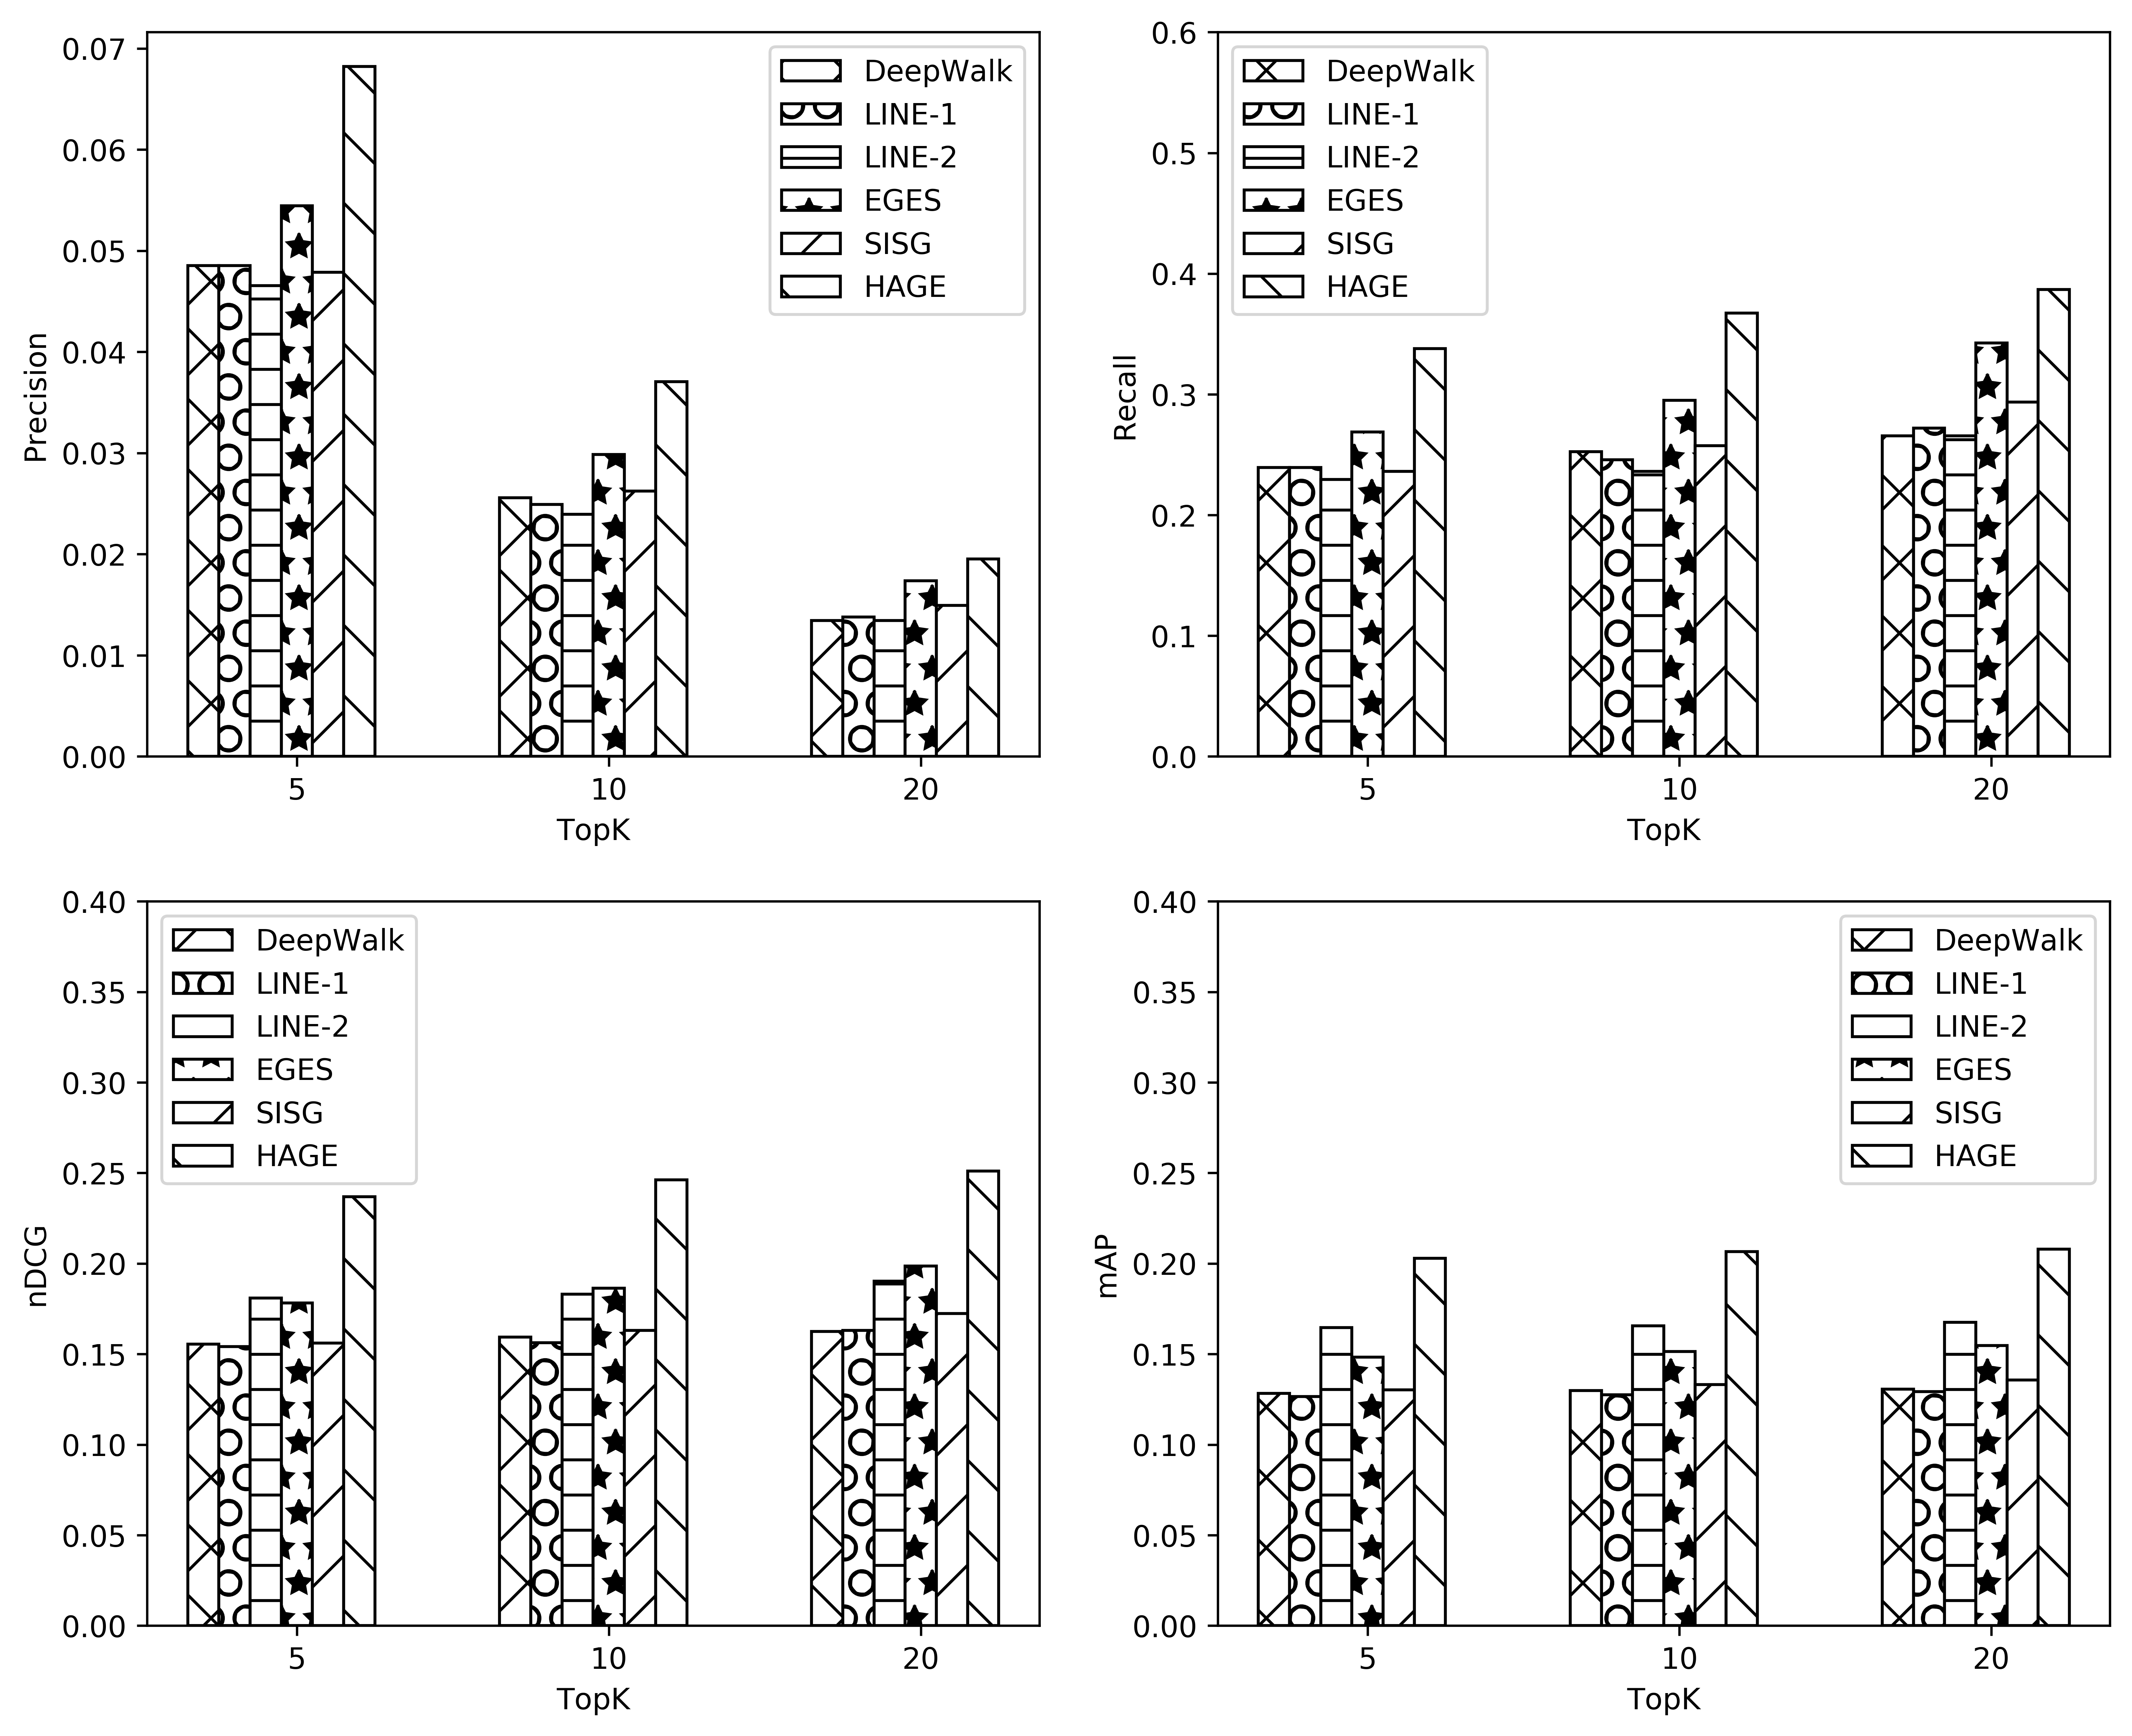

In [307]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)
width = 0.1
hatch_list = ['x', 'O', '-', '*', '/', '\\']

# precision
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
precision_at_5s = douban_concat_dataframe.loc[:, "precision_at_5"].to_list()
precision_at_10s = douban_concat_dataframe.loc[:, "precision_at_10"].to_list()
precision_at_20s = douban_concat_dataframe.loc[:, "precision_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    precisions = [precision_at_5s[i], precision_at_10s[i], precision_at_20s[i]]
    ax[0, 0].bar(positions+i*width, precisions, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 0].set_xticks(positions+len(algorithms)*width/2)
ax[0, 0].set_xticklabels(["5", "10", "20"])
ax[0, 0].set_xlabel("TopK")
ax[0, 0].set_ylabel("Precision")
ax[0, 0].legend(loc="best")

# recall
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
recall_at_5s = douban_concat_dataframe.loc[:, "recall_at_5"].to_list()
recall_at_10s = douban_concat_dataframe.loc[:, "recall_at_10"].to_list()
recall_at_20s = douban_concat_dataframe.loc[:, "recall_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    recalls = [recall_at_5s[i], recall_at_10s[i], recall_at_20s[i]]
    ax[0, 1].bar(positions+i*width, recalls, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 1].set_xticks(positions+len(algorithms)*width/2)
ax[0, 1].set_xticklabels(["5", "10", "20"])
ax[0, 1].set_xlabel("TopK")
ax[0, 1].set_ylabel("Recall")
ax[0, 1].legend(loc="best")

ax[0, 1].set_ylim(ymax = 0.6)

# ndcg
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
ndcg_at_5s = douban_concat_dataframe.loc[:, "ndcg_at_5"].to_list()
ndcg_at_10s = douban_concat_dataframe.loc[:, "ndcg_at_10"].to_list()
ndcg_at_20s = douban_concat_dataframe.loc[:, "ndcg_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    ndcgs = [ndcg_at_5s[i], ndcg_at_10s[i], ndcg_at_20s[i]]
    ax[1, 0].bar(positions+i*width, ndcgs, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 0].set_xticks(positions+len(algorithms)*width/2)
ax[1, 0].set_xticklabels(["5", "10", "20"])
ax[1, 0].set_xlabel("TopK")
ax[1, 0].set_ylabel("nDCG")
ax[1, 0].legend(loc="best")

ax[1, 0].set_ylim(ymax = 0.4)

# map
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
map_at_5s = douban_concat_dataframe.loc[:, "map_at_5"].to_list()
map_at_10s = douban_concat_dataframe.loc[:, "map_at_10"].to_list()
map_at_20s = douban_concat_dataframe.loc[:, "map_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    maps = [map_at_5s[i], map_at_10s[i], map_at_20s[i]]
    ax[1, 1].bar(positions+i*width, maps, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 1].set_xticks(positions+len(algorithms)*width/2)
ax[1, 1].set_xticklabels(["5", "10", "20"])
ax[1, 1].set_xlabel("TopK")
ax[1, 1].set_ylabel("mAP")
ax[1, 1].legend(loc="best")

ax[1, 1].set_ylim(ymax = 0.4)

fig.savefig('D:/Developer/recommender-experiments/experiment1/notebook/images/evaluations.eps', dpi=600, format="eps")
fig.savefig("D:/Developer/recommender-experiments/experiment1/notebook/images/evaluations.png", dpi=600, format="png")

In [308]:
amazon = EvaluatePartition("../data/amazon")

users: 305, events: 280


In [309]:
with elapsed_timer("-- {0}s - %s" % ("DeepWalk",)):
    amazon.add_evaluation(experiment2_amazon_file("deepwalk.tsv"), "partition", partition=1, algorithm="DeepWalk", model_params="DeepWalk")
with elapsed_timer("-- {0}s - %s" % ("LINE-1",)):
    amazon.add_evaluation(experiment2_amazon_file("line1.tsv"), "partition", partition=1, algorithm="LINE-1", model_params="LINE-1")
with elapsed_timer("-- {0}s - %s" % ("LINE-2",)):
    amazon.add_evaluation(experiment2_amazon_file("line2.tsv"), "partition", partition=1, algorithm="LINE-2", model_params="LINE-2")
with elapsed_timer("-- {0}s - %s" % ("EGES",)):
    amazon.add_evaluation(amazon_file("EGES.tsv"), "partition", partition=1, algorithm="EGES", model_params="EGES")
with elapsed_timer("-- {0}s - %s" % ("SISG",)):
    amazon.add_evaluation(amazon_file("app.tsv"), "partition", partition=1, algorithm="SISG", model_params="SISG")
with elapsed_timer("-- {0}s - %s" % ("CSE-MF",)):
    amazon.add_evaluation(experiment2_amazon_file("nemf.tsv"), "partition", partition=1, algorithm="CSE-MF", model_params="CSE-MF")
with elapsed_timer("-- {0}s - %s" % ("CSE-Rank",)):
    amazon.add_evaluation(experiment2_amazon_file("nerank.tsv"), "partition", partition=1, algorithm="CSE-Rank", model_params="CSE-Rank")

-- 9.809931516647339s - DeepWalk
-- 9.557085990905762s - LINE-1
-- 9.042406797409058s - LINE-2
-- 9.362207174301147s - EGES
-- 9.311238050460815s - SISG
-- 9.209302425384521s - CSE-MF
-- 9.241282939910889s - CSE-Rank


In [310]:
douban_concat_dataframe = amazon.group_evaluations["partition"]
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.006492,0.013770,0.025902,0.047869,0.321311,0.272131,0.255738,0.236066,0.012726,0.026214,0.047039,0.079597,0.196541,0.187050,0.183046,0.176547,0.160280,0.159254,0.156503,26.214815,0.0,1.0,1.0,0.561688,1,DeepWalk,DeepWalk
1,0.006951,0.013934,0.025902,0.048525,0.344262,0.275410,0.255738,0.239344,0.013627,0.026527,0.047039,0.080690,0.176605,0.162939,0.157998,0.152588,0.128015,0.126671,0.124372,30.183007,0.0,1.0,1.0,0.503247,1,LINE-1,LINE-1
2,0.003869,0.004098,0.002951,0.002623,0.188525,0.078689,0.026230,0.009836,0.007582,0.007791,0.005305,0.004142,0.047923,0.026491,0.013286,0.008363,0.013068,0.009467,0.007650,48.276786,0.0,1.0,1.0,0.636364,1,LINE-2,LINE-2
3,0.008328,0.017377,0.029836,0.054426,0.411475,0.342623,0.295082,0.268852,0.016325,0.033077,0.054193,0.090526,0.212091,0.198512,0.186436,0.178276,0.154744,0.151488,0.148306,27.643678,0.0,1.0,1.0,0.435065,1,EGES,EGES
4,0.007279,0.014918,0.026230,0.047869,0.359016,0.293443,0.257377,0.236066,0.014268,0.028393,0.047607,0.079597,0.185478,0.172337,0.163055,0.156047,0.135745,0.133106,0.130273,20.227273,0.0,1.0,1.0,0.571429,1,SISG,SISG
5,0.007869,0.014590,0.025574,0.047869,0.386885,0.288525,0.252459,0.236066,0.015424,0.027776,0.046443,0.079597,0.199106,0.179835,0.170782,0.165408,0.146788,0.144334,0.142077,30.621302,0.0,1.0,1.0,0.451299,1,CSE-MF,CSE-MF
6,0.007148,0.014262,0.025246,0.046557,0.352459,0.280328,0.247541,0.227869,0.014011,0.027144,0.045819,0.077318,0.222849,0.208751,0.200855,0.194638,0.187335,0.185377,0.182896,23.072464,0.0,1.0,1.0,0.551948,1,CSE-Rank,CSE-Rank


In [311]:
copy = douban_concat_dataframe.copy()
# douban_concat_dataframe = copy.copy()

In [312]:
experiment2_amazon = EvaluatePartition("../../experiment2/data/amazon")

users: 305, events: 280


In [313]:
with elapsed_timer("-- {0}s - %s" % ("CIGE",)):
    experiment2_amazon.add_evaluation(experiment2_amazon_file("CIGE4.tsv"), "partition", partition=1, algorithm="CIGE", model_params="CIGE")
    experiment2_amazon.add_evaluation(experiment2_amazon_file("CIGE_Cold.tsv"), "partition", partition=1, algorithm="CIGE-Cold", model_params="CIGE-Cold")

-- 18.142773151397705s - CIGE


In [314]:
# with elapsed_timer("-- {0}s - %s" % ("HIGE",)):
#     experiment2_amazon.add_evaluation(experiment2_amazon_file("node2vec.tsv"), "partition", partition=1, algorithm="HIGE", model_params="HIGE")

In [315]:
experiment2_amazon.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.008262,0.016066,0.030164,0.056393,0.408197,0.318033,0.298361,0.278689,0.016197,0.030586,0.054789,0.093805,0.218881,0.201019,0.196024,0.189922,0.164371,0.162995,0.160628,26.337349,0.0,1.0,1.0,0.461039,1,CIGE,CIGE
1,0.008656,0.017213,0.031148,0.049180,0.427869,0.340984,0.308197,0.244262,0.016968,0.032772,0.056577,0.081876,0.218511,0.201466,0.193127,0.171232,0.158970,0.156652,0.146749,22.768293,0.0,1.0,1.0,0.467532,1,CIGE-Cold,CIGE-Cold


In [316]:
douban_concat_dataframe = pd.concat([douban_concat_dataframe, experiment2_amazon.group_evaluations["partition"]],axis=0,ignore_index=True)
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.006492,0.013770,0.025902,0.047869,0.321311,0.272131,0.255738,0.236066,0.012726,0.026214,0.047039,0.079597,0.196541,0.187050,0.183046,0.176547,0.160280,0.159254,0.156503,26.214815,0.0,1.0,1.0,0.561688,1,DeepWalk,DeepWalk
1,0.006951,0.013934,0.025902,0.048525,0.344262,0.275410,0.255738,0.239344,0.013627,0.026527,0.047039,0.080690,0.176605,0.162939,0.157998,0.152588,0.128015,0.126671,0.124372,30.183007,0.0,1.0,1.0,0.503247,1,LINE-1,LINE-1
2,0.003869,0.004098,0.002951,0.002623,0.188525,0.078689,0.026230,0.009836,0.007582,0.007791,0.005305,0.004142,0.047923,0.026491,0.013286,0.008363,0.013068,0.009467,0.007650,48.276786,0.0,1.0,1.0,0.636364,1,LINE-2,LINE-2
3,0.008328,0.017377,0.029836,0.054426,0.411475,0.342623,0.295082,0.268852,0.016325,0.033077,0.054193,0.090526,0.212091,0.198512,0.186436,0.178276,0.154744,0.151488,0.148306,27.643678,0.0,1.0,1.0,0.435065,1,EGES,EGES
4,0.007279,0.014918,0.026230,0.047869,0.359016,0.293443,0.257377,0.236066,0.014268,0.028393,0.047607,0.079597,0.185478,0.172337,0.163055,0.156047,0.135745,0.133106,0.130273,20.227273,0.0,1.0,1.0,0.571429,1,SISG,SISG
5,0.007869,0.014590,0.025574,0.047869,0.386885,0.288525,0.252459,0.236066,0.015424,0.027776,0.046443,0.079597,0.199106,0.179835,0.170782,0.165408,0.146788,0.144334,0.142077,30.621302,0.0,1.0,1.0,0.451299,1,CSE-MF,CSE-MF
6,0.007148,0.014262,0.025246,0.046557,0.352459,0.280328,0.247541,0.227869,0.014011,0.027144,0.045819,0.077318,0.222849,0.208751,0.200855,0.194638,0.187335,0.185377,0.182896,23.072464,0.0,1.0,1.0,0.551948,1,CSE-Rank,CSE-Rank
7,0.008262,0.016066,0.030164,0.056393,0.408197,0.318033,0.298361,0.278689,0.016197,0.030586,0.054789,0.093805,0.218881,0.201019,0.196024,0.189922,0.164371,0.162995,0.160628,26.337349,0.0,1.0,1.0,0.461039,1,CIGE,CIGE
8,0.008656,0.017213,0.031148,0.049180,0.427869,0.340984,0.308197,0.244262,0.016968,0.032772,0.056577,0.081876,0.218511,0.201466,0.193127,0.171232,0.158970,0.156652,0.146749,22.768293,0.0,1.0,1.0,0.467532,1,CIGE-Cold,CIGE-Cold


C:\Users\yingy\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


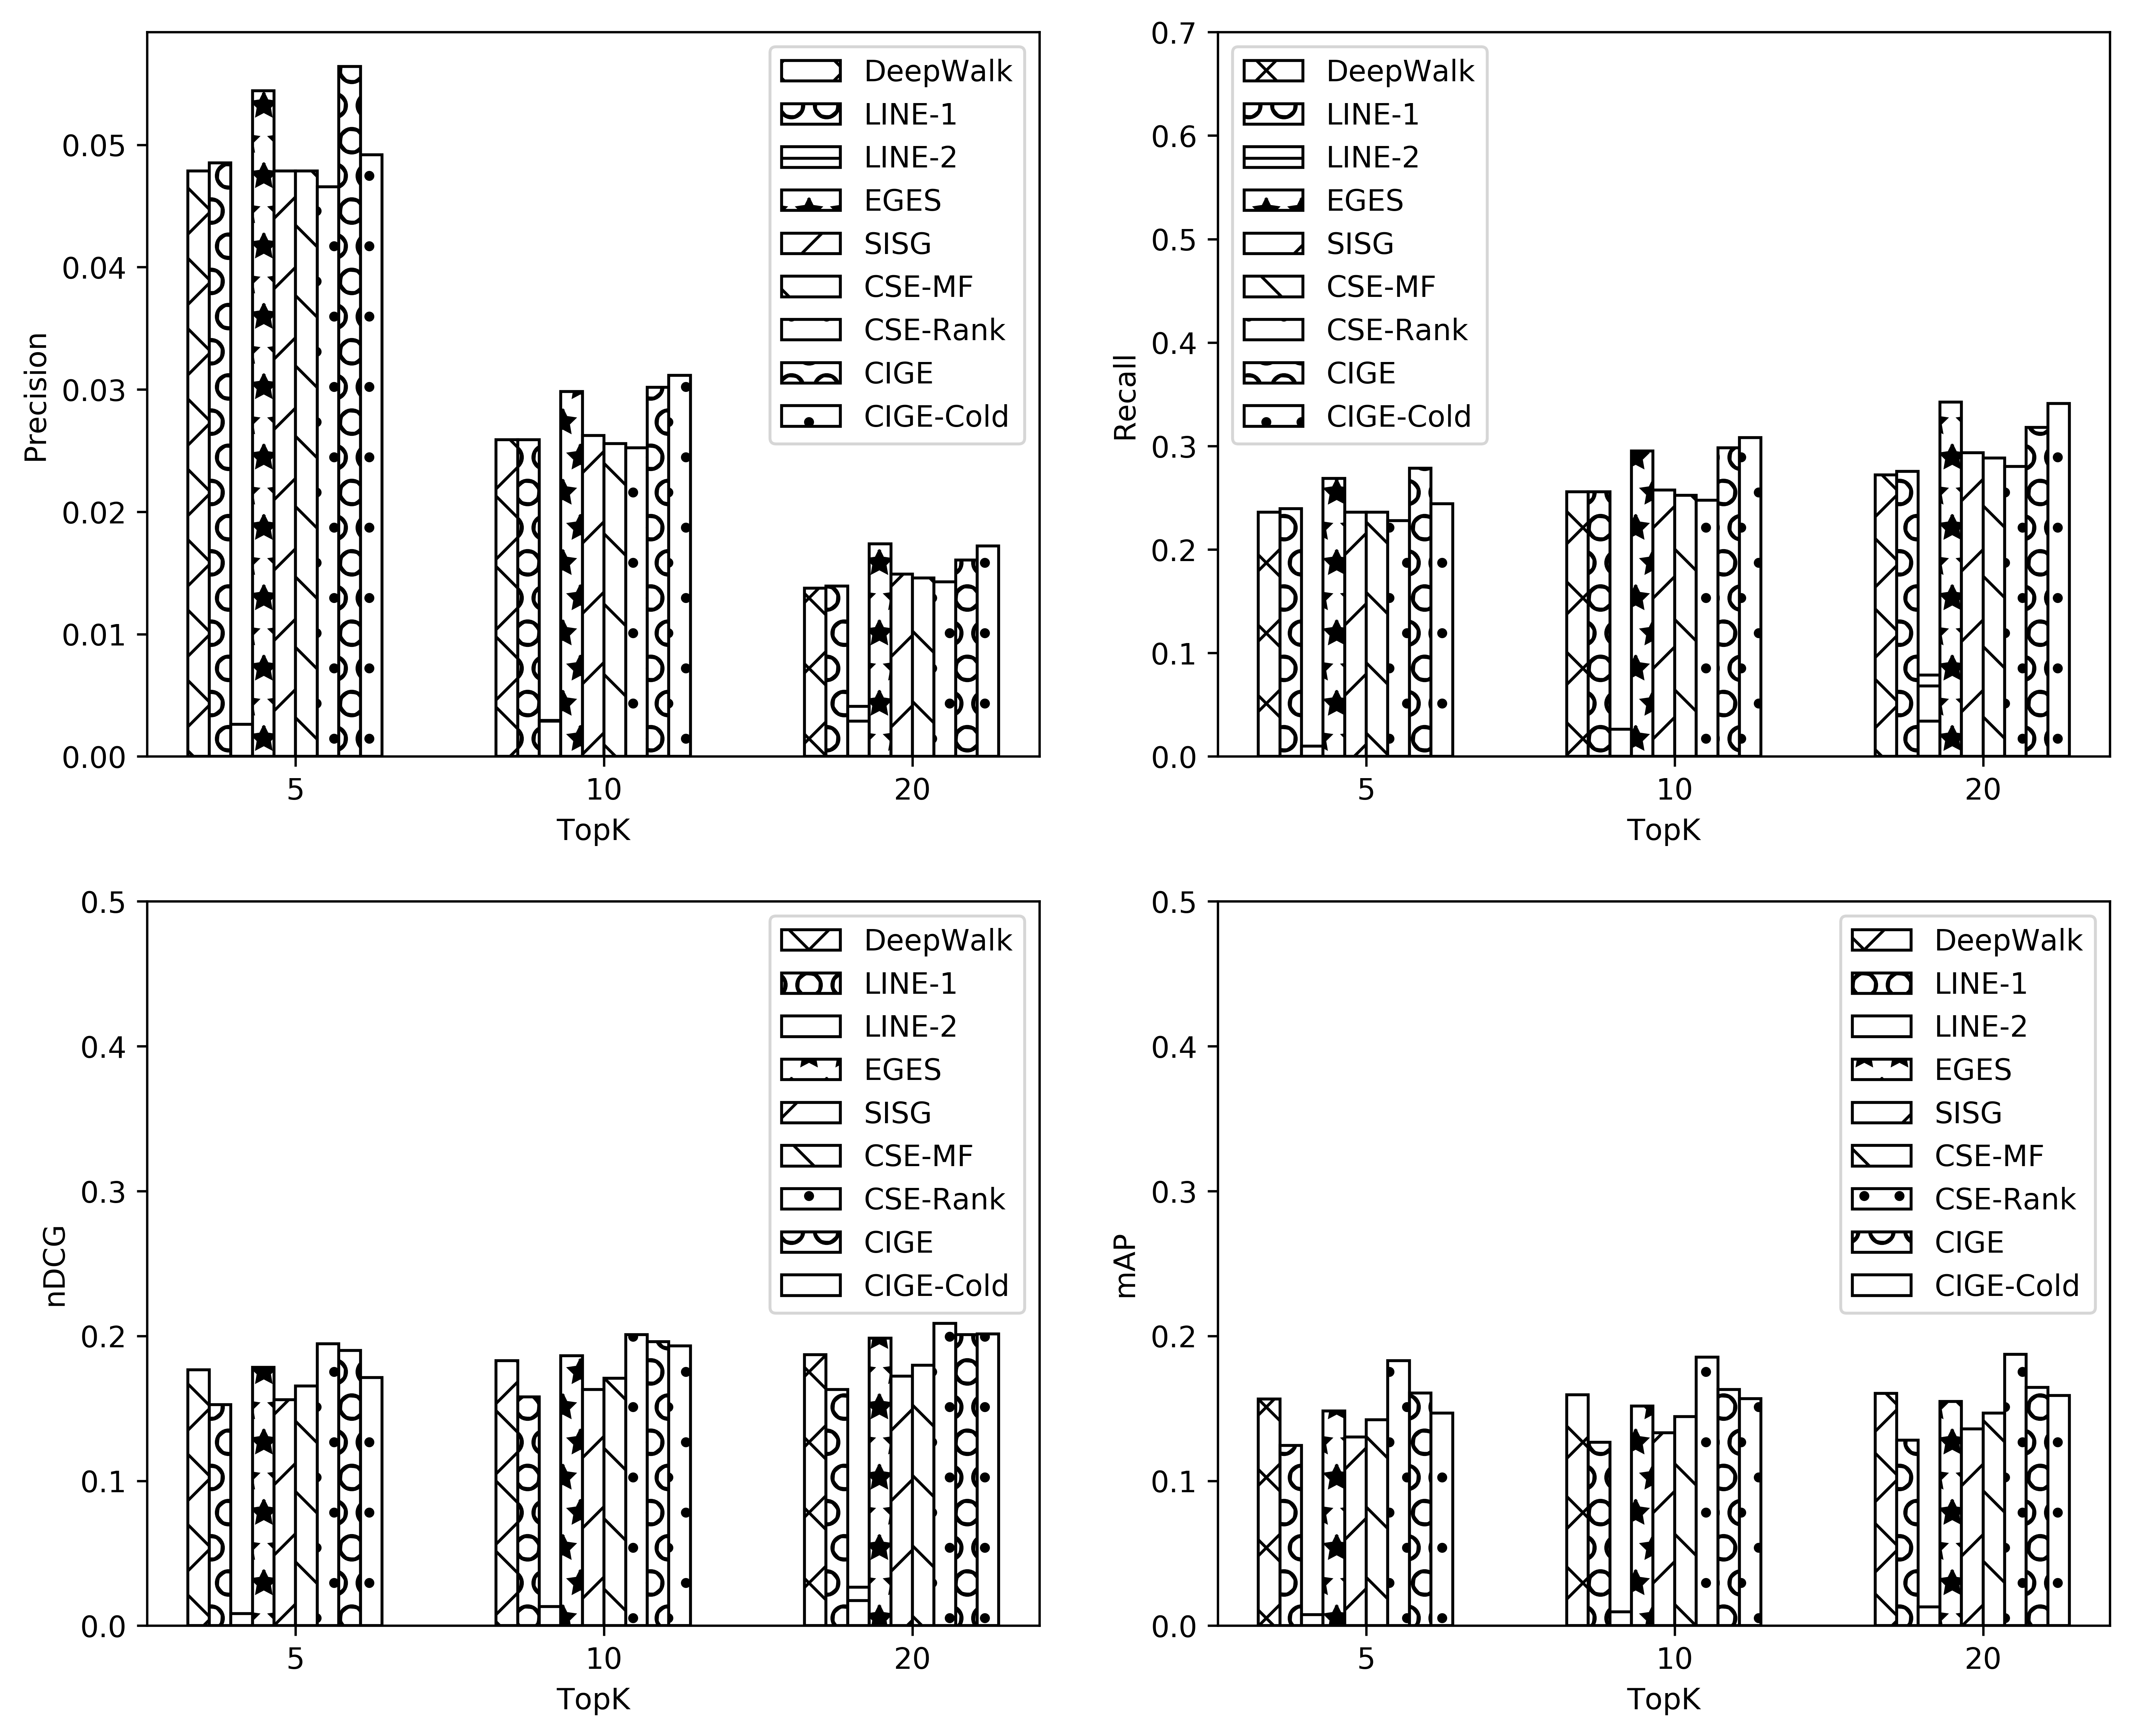

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)
width = 0.07
hatch_list = ['x', 'O', '-', '*', '/', '\\', '.', 'O', '.', 'o']

# precision
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
precision_at_5s = douban_concat_dataframe.loc[:, "precision_at_5"].to_list()
precision_at_10s = douban_concat_dataframe.loc[:, "precision_at_10"].to_list()
precision_at_20s = douban_concat_dataframe.loc[:, "precision_at_20"].to_list()

positions = np.arange(3)

for i, algorithm in enumerate(algorithms):
    precisions = [precision_at_5s[i], precision_at_10s[i], precision_at_20s[i]]
    ax[0, 0].bar(positions+i*width, precisions, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 0].set_xticks(positions+len(algorithms)*width/2)
ax[0, 0].set_xticklabels(["5", "10", "20"])
ax[0, 0].set_xlabel("TopK")
ax[0, 0].set_ylabel("Precision")
ax[0, 0].legend(loc="best")

# recall
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
recall_at_5s = douban_concat_dataframe.loc[:, "recall_at_5"].to_list()
recall_at_10s = douban_concat_dataframe.loc[:, "recall_at_10"].to_list()
recall_at_20s = douban_concat_dataframe.loc[:, "recall_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    recalls = [recall_at_5s[i], recall_at_10s[i], recall_at_20s[i]]
    ax[0, 1].bar(positions+i*width, recalls, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 1].set_xticks(positions+len(algorithms)*width/2)
ax[0, 1].set_xticklabels(["5", "10", "20"])
ax[0, 1].set_xlabel("TopK")
ax[0, 1].set_ylabel("Recall")
ax[0, 1].legend(loc="best")

ax[0, 1].set_ylim(ymax = 0.7)

# ndcg
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
ndcg_at_5s = douban_concat_dataframe.loc[:, "ndcg_at_5"].to_list()
ndcg_at_10s = douban_concat_dataframe.loc[:, "ndcg_at_10"].to_list()
ndcg_at_20s = douban_concat_dataframe.loc[:, "ndcg_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    ndcgs = [ndcg_at_5s[i], ndcg_at_10s[i], ndcg_at_20s[i]]
    ax[1, 0].bar(positions+i*width, ndcgs, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 0].set_xticks(positions+len(algorithms)*width/2)
ax[1, 0].set_xticklabels(["5", "10", "20"])
ax[1, 0].set_xlabel("TopK")
ax[1, 0].set_ylabel("nDCG")
ax[1, 0].legend(loc="best")

ax[1, 0].set_ylim(ymax = 0.5)

# map
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
map_at_5s = douban_concat_dataframe.loc[:, "map_at_5"].to_list()
map_at_10s = douban_concat_dataframe.loc[:, "map_at_10"].to_list()
map_at_20s = douban_concat_dataframe.loc[:, "map_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    maps = [map_at_5s[i], map_at_10s[i], map_at_20s[i]]
    ax[1, 1].bar(positions+i*width, maps, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 1].set_xticks(positions+len(algorithms)*width/2)
ax[1, 1].set_xticklabels(["5", "10", "20"])
ax[1, 1].set_xlabel("TopK")
ax[1, 1].set_ylabel("mAP")
ax[1, 1].legend(loc="best")

ax[1, 1].set_ylim(ymax = 0.5)

fig.savefig('D:/Developer/recommender-experiments/experiment2/notebook/images/evaluations.eps', dpi=600, format="eps")
fig.savefig("D:/Developer/recommender-experiments/experiment2/notebook/images/evaluations.png", dpi=600, format="png")

In [318]:
douban_concat_dataframe = copy.copy()

In [319]:
experiment2_amazon = EvaluatePartition("../../experiment2/data/amazon")

users: 305, events: 280


In [320]:
with elapsed_timer("-- {0}s - %s" % ("CIGE",)):
    experiment2_amazon.add_evaluation(experiment2_amazon_file("CIGE4.tsv"), "partition", partition=1, algorithm="CIGE", model_params="CIGE")
#     experiment2_amazon.add_evaluation(experiment2_amazon_file("CIGE_Cold.tsv"), "partition", partition=1, algorithm="CIGE-Cold", model_params="CIGE-Cold")

-- 9.431166172027588s - CIGE


In [321]:
with elapsed_timer("-- {0}s - %s" % ("HIGE",)):
    experiment2_amazon.add_evaluation(experiment2_amazon_file("node2vec.tsv"), "partition", partition=1, algorithm="HIGE", model_params="HIGE")

-- 5.768431186676025s - HIGE


In [322]:
douban_concat_dataframe = pd.concat([douban_concat_dataframe, experiment2_amazon.group_evaluations["partition"]],axis=0,ignore_index=True)
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.006492,0.013770,0.025902,0.047869,0.321311,0.272131,0.255738,0.236066,0.012726,0.026214,0.047039,0.079597,0.196541,0.187050,0.183046,0.176547,0.160280,0.159254,0.156503,26.214815,0.0,1.0,1.0,0.561688,1,DeepWalk,DeepWalk
1,0.006951,0.013934,0.025902,0.048525,0.344262,0.275410,0.255738,0.239344,0.013627,0.026527,0.047039,0.080690,0.176605,0.162939,0.157998,0.152588,0.128015,0.126671,0.124372,30.183007,0.0,1.0,1.0,0.503247,1,LINE-1,LINE-1
2,0.003869,0.004098,0.002951,0.002623,0.188525,0.078689,0.026230,0.009836,0.007582,0.007791,0.005305,0.004142,0.047923,0.026491,0.013286,0.008363,0.013068,0.009467,0.007650,48.276786,0.0,1.0,1.0,0.636364,1,LINE-2,LINE-2
3,0.008328,0.017377,0.029836,0.054426,0.411475,0.342623,0.295082,0.268852,0.016325,0.033077,0.054193,0.090526,0.212091,0.198512,0.186436,0.178276,0.154744,0.151488,0.148306,27.643678,0.0,1.0,1.0,0.435065,1,EGES,EGES
4,0.007279,0.014918,0.026230,0.047869,0.359016,0.293443,0.257377,0.236066,0.014268,0.028393,0.047607,0.079597,0.185478,0.172337,0.163055,0.156047,0.135745,0.133106,0.130273,20.227273,0.0,1.0,1.0,0.571429,1,SISG,SISG
5,0.007869,0.014590,0.025574,0.047869,0.386885,0.288525,0.252459,0.236066,0.015424,0.027776,0.046443,0.079597,0.199106,0.179835,0.170782,0.165408,0.146788,0.144334,0.142077,30.621302,0.0,1.0,1.0,0.451299,1,CSE-MF,CSE-MF
6,0.007148,0.014262,0.025246,0.046557,0.352459,0.280328,0.247541,0.227869,0.014011,0.027144,0.045819,0.077318,0.222849,0.208751,0.200855,0.194638,0.187335,0.185377,0.182896,23.072464,0.0,1.0,1.0,0.551948,1,CSE-Rank,CSE-Rank
7,0.008262,0.016066,0.030164,0.056393,0.408197,0.318033,0.298361,0.278689,0.016197,0.030586,0.054789,0.093805,0.218881,0.201019,0.196024,0.189922,0.164371,0.162995,0.160628,26.337349,0.0,1.0,1.0,0.461039,1,CIGE,CIGE
8,0.007604,0.017187,0.030729,0.059375,0.372396,0.335938,0.299479,0.289062,0.014904,0.032702,0.055739,0.098515,0.204171,0.197029,0.187936,0.184863,0.153874,0.151447,0.150347,24.750000,0.0,1.0,1.0,0.507692,1,HIGE,HIGE


C:\Users\yingy\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


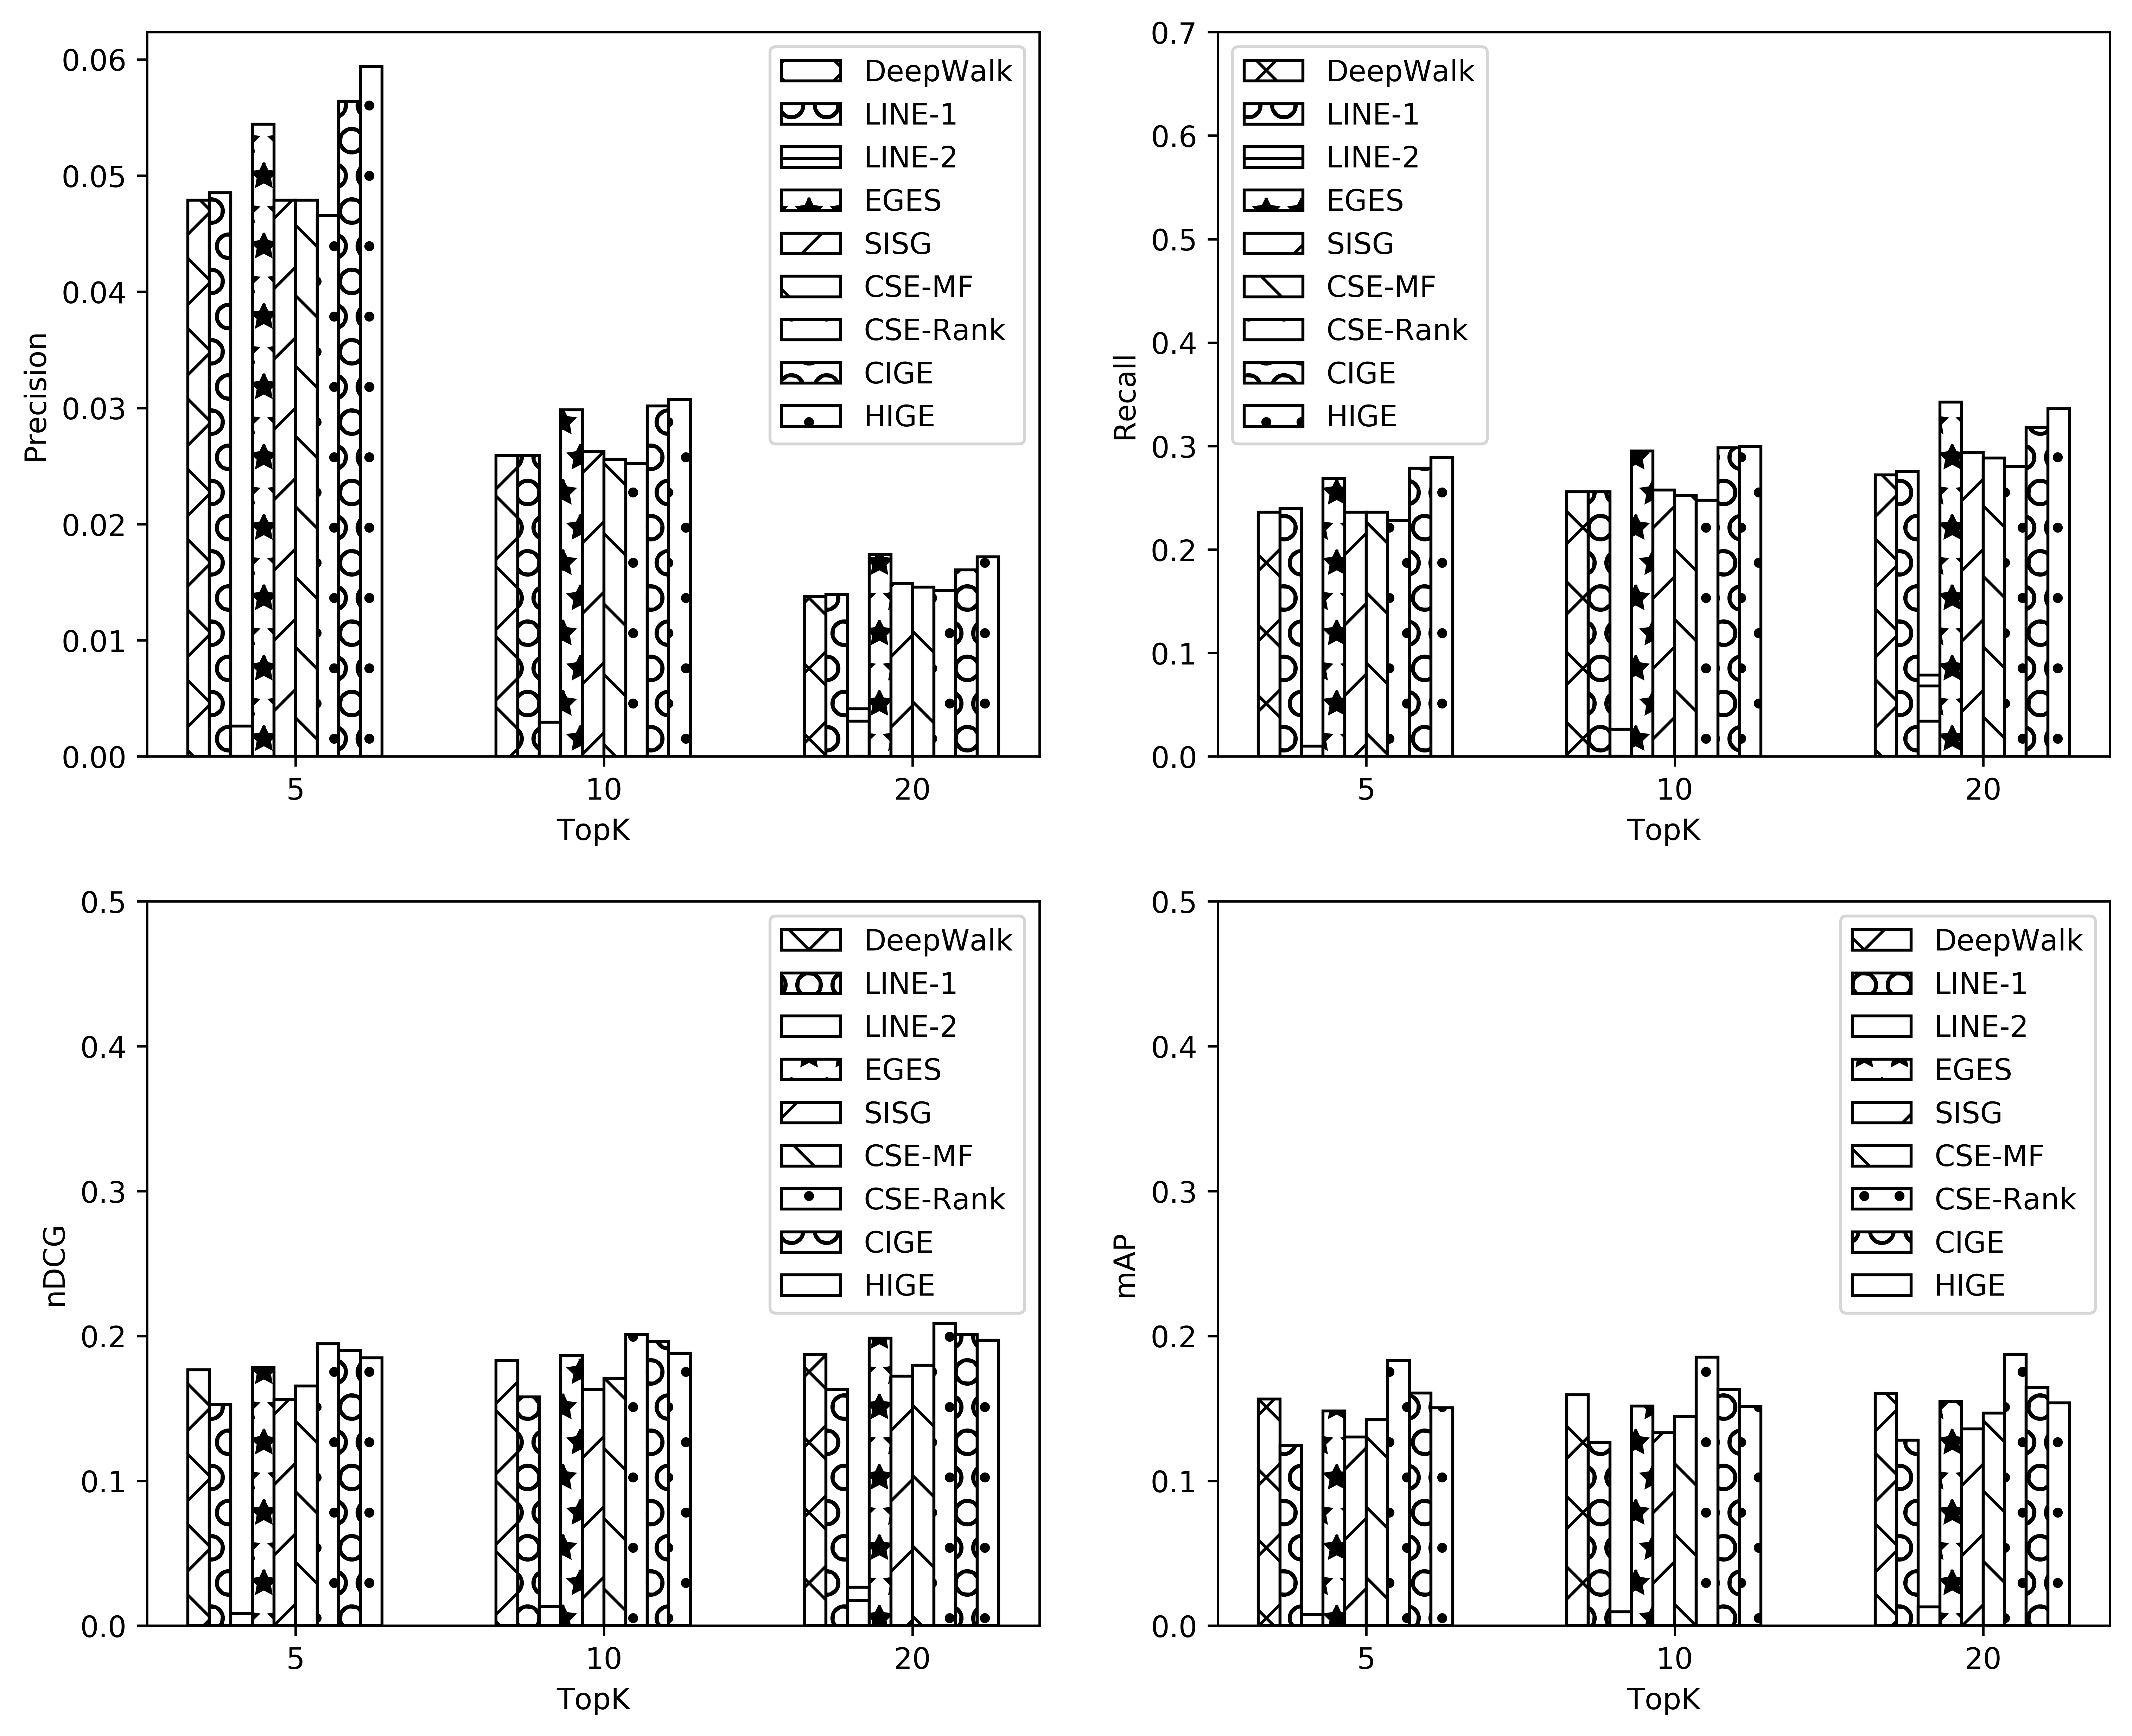

In [323]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)
width = 0.07
hatch_list = ['x', 'O', '-', '*', '/', '\\', '.', 'O', '.', 'o']

# precision
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
precision_at_5s = douban_concat_dataframe.loc[:, "precision_at_5"].to_list()
precision_at_10s = douban_concat_dataframe.loc[:, "precision_at_10"].to_list()
precision_at_20s = douban_concat_dataframe.loc[:, "precision_at_20"].to_list()

positions = np.arange(3)

for i, algorithm in enumerate(algorithms):
    precisions = [precision_at_5s[i], precision_at_10s[i], precision_at_20s[i]]
    ax[0, 0].bar(positions+i*width, precisions, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 0].set_xticks(positions+len(algorithms)*width/2)
ax[0, 0].set_xticklabels(["5", "10", "20"])
ax[0, 0].set_xlabel("TopK")
ax[0, 0].set_ylabel("Precision")
ax[0, 0].legend(loc="best")

# recall
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
recall_at_5s = douban_concat_dataframe.loc[:, "recall_at_5"].to_list()
recall_at_10s = douban_concat_dataframe.loc[:, "recall_at_10"].to_list()
recall_at_20s = douban_concat_dataframe.loc[:, "recall_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    recalls = [recall_at_5s[i], recall_at_10s[i], recall_at_20s[i]]
    ax[0, 1].bar(positions+i*width, recalls, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[0, 1].set_xticks(positions+len(algorithms)*width/2)
ax[0, 1].set_xticklabels(["5", "10", "20"])
ax[0, 1].set_xlabel("TopK")
ax[0, 1].set_ylabel("Recall")
ax[0, 1].legend(loc="best")

ax[0, 1].set_ylim(ymax = 0.7)

# ndcg
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
ndcg_at_5s = douban_concat_dataframe.loc[:, "ndcg_at_5"].to_list()
ndcg_at_10s = douban_concat_dataframe.loc[:, "ndcg_at_10"].to_list()
ndcg_at_20s = douban_concat_dataframe.loc[:, "ndcg_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    ndcgs = [ndcg_at_5s[i], ndcg_at_10s[i], ndcg_at_20s[i]]
    ax[1, 0].bar(positions+i*width, ndcgs, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 0].set_xticks(positions+len(algorithms)*width/2)
ax[1, 0].set_xticklabels(["5", "10", "20"])
ax[1, 0].set_xlabel("TopK")
ax[1, 0].set_ylabel("nDCG")
ax[1, 0].legend(loc="best")

ax[1, 0].set_ylim(ymax = 0.5)

# map
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
map_at_5s = douban_concat_dataframe.loc[:, "map_at_5"].to_list()
map_at_10s = douban_concat_dataframe.loc[:, "map_at_10"].to_list()
map_at_20s = douban_concat_dataframe.loc[:, "map_at_20"].to_list()

positions = np.arange(3)
for i, algorithm in enumerate(algorithms):
    maps = [map_at_5s[i], map_at_10s[i], map_at_20s[i]]
    ax[1, 1].bar(positions+i*width, maps, width, label=algorithm, color="w",edgecolor="k", hatch=hatch_list[i])
ax[1, 1].set_xticks(positions+len(algorithms)*width/2)
ax[1, 1].set_xticklabels(["5", "10", "20"])
ax[1, 1].set_xlabel("TopK")
ax[1, 1].set_ylabel("mAP")
ax[1, 1].legend(loc="best")

ax[1, 1].set_ylim(ymax = 0.5)

fig.savefig('D:/Developer/recommender-experiments/experiment2/notebook/images/evaluations2.eps', dpi=600, format="eps")
fig.savefig("D:/Developer/recommender-experiments/experiment2/notebook/images/evaluations2.png", dpi=600, format="png")

In [324]:
import sys
print(sys.executable)

C:\Users\yingy\Anaconda3\python.exe
